<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('BHPD2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : BHPD2
Run time             : Tuesday 09 February 2021, 18:32:22
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [2]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### 2.2 - Option 2 : From a csv file
More fun !

In [3]:
data = pd.read_csv(f'{datasets_dir}/BHPD/origine/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [4]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.71,10.06,11.32,0.06,0.55,6.28,68.75,3.75,9.66,409.98,18.57,359.04,12.59
std,9.21,22.07,6.87,0.24,0.11,0.71,27.93,2.05,8.81,171.70,2.13,88.47,7.11
min,0.01,0.00,1.21,0.00,0.39,3.56,6.20,1.13,1.00,187.00,12.60,2.52,1.73
25%,0.09,0.00,5.19,0.00,0.45,5.89,45.02,2.11,4.00,279.00,17.40,375.93,7.12
50%,0.29,0.00,9.69,0.00,0.54,6.17,76.70,3.21,5.00,329.00,19.20,391.64,11.31
75%,3.69,0.00,18.10,0.00,0.62,6.61,94.10,5.11,24.00,666.00,20.20,396.32,16.96
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.40,-0.46,-1.47,-0.25,-1.49,-3.82,-2.24,-1.28,-0.98,-1.30,-2.80,-4.03,-1.53
25%,-0.39,-0.46,-0.89,-0.25,-0.91,-0.55,-0.85,-0.80,-0.64,-0.76,-0.55,0.19,-0.77
50%,-0.37,-0.46,-0.24,-0.25,-0.14,-0.16,0.28,-0.27,-0.53,-0.47,0.30,0.37,-0.18
75%,-0.00,-0.46,0.99,-0.25,0.63,0.46,0.91,0.66,1.63,1.49,0.77,0.42,0.61
max,9.26,4.08,2.39,3.98,2.86,3.52,1.12,4.09,1.63,1.75,1.61,0.43,3.57


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (13,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [8]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [9]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100


 1/36 [..............................] - ETA: 34s - loss: 484.2044 - mae: 21.0101 - mse: 484.2044

33/36 [==========================>...] - ETA: 0s - loss: 590.6685 - mae: 22.3240 - mse: 590.6685 

36/36 [==============================] - 2s 24ms/step - loss: 583.1686 - mae: 22.1574 - mse: 583.1686 - val_loss: 377.3661 - val_mae: 17.7221 - val_mse: 377.3661


Epoch 2/100
 1/36 [..............................] - ETA: 0s - loss: 266.4621 - mae: 14.9045 - mse: 266.4621

34/36 [===========================>..] - ETA: 0s - loss: 341.1813 - mae: 16.3934 - mse: 341.1813

36/36 [==============================] - 0s 4ms/step - loss: 337.8587 - mae: 16.2857 - mse: 337.8587 - val_loss: 136.7503 - val_mae: 9.7103 - val_mse: 136.7503


Epoch 3/100
 1/36 [..............................] - ETA: 0s - loss: 129.1002 - mae: 10.3502 - mse: 129.1002

34/36 [===========================>..] - ETA: 0s - loss: 159.5503 - mae: 9.9416 - mse: 159.5503 

36/36 [==============================] - 0s 4ms/step - loss: 155.8843 - mae: 9.8114 - mse: 155.8843 - val_loss: 42.4420 - val_mae: 5.3457 - val_mse: 42.4420


Epoch 4/100
 1/36 [..............................] - ETA: 0s - loss: 78.2601 - mae: 8.1654 - mse: 78.2601

34/36 [===========================>..] - ETA: 0s - loss: 57.6928 - mae: 5.8249 - mse: 57.6928

36/36 [==============================] - 0s 4ms/step - loss: 56.8585 - mae: 5.7622 - mse: 56.8585 - val_loss: 24.8297 - val_mae: 3.9789 - val_mse: 24.8297


Epoch 5/100
 1/36 [..............................] - ETA: 0s - loss: 39.3440 - mae: 5.0342 - mse: 39.3440

34/36 [===========================>..] - ETA: 0s - loss: 32.9805 - mae: 4.3313 - mse: 32.9805

36/36 [==============================] - 0s 4ms/step - loss: 32.7620 - mae: 4.3087 - mse: 32.7620 - val_loss: 16.9794 - val_mae: 3.1939 - val_mse: 16.9794


Epoch 6/100
 1/36 [..............................] - ETA: 0s - loss: 8.6408 - mae: 2.3973 - mse: 8.6408

34/36 [===========================>..] - ETA: 0s - loss: 22.1364 - mae: 3.4409 - mse: 22.1364

36/36 [==============================] - 0s 4ms/step - loss: 22.3164 - mae: 3.4525 - mse: 22.3164 - val_loss: 13.1099 - val_mae: 2.8000 - val_mse: 13.1099


Epoch 7/100
 1/36 [..............................] - ETA: 0s - loss: 7.5334 - mae: 2.3887 - mse: 7.5334

34/36 [===========================>..] - ETA: 0s - loss: 22.6858 - mae: 3.2849 - mse: 22.6858

36/36 [==============================] - 0s 4ms/step - loss: 22.6141 - mae: 3.2865 - mse: 22.6141 - val_loss: 12.7304 - val_mae: 2.7439 - val_mse: 12.7304


Epoch 8/100
 1/36 [..............................] - ETA: 0s - loss: 7.7428 - mae: 2.0614 - mse: 7.7428

34/36 [===========================>..] - ETA: 0s - loss: 20.6127 - mae: 3.1184 - mse: 20.6127

36/36 [==============================] - 0s 4ms/step - loss: 20.5548 - mae: 3.1194 - mse: 20.5548 - val_loss: 12.1652 - val_mae: 2.6725 - val_mse: 12.1652


Epoch 9/100
 1/36 [..............................] - ETA: 0s - loss: 11.0402 - mae: 2.4000 - mse: 11.0402

34/36 [===========================>..] - ETA: 0s - loss: 13.6448 - mae: 2.7332 - mse: 13.6448

36/36 [==============================] - 0s 4ms/step - loss: 14.0578 - mae: 2.7583 - mse: 14.0578 - val_loss: 11.3440 - val_mae: 2.5878 - val_mse: 11.3440


Epoch 10/100
 1/36 [..............................] - ETA: 0s - loss: 10.1019 - mae: 2.6531 - mse: 10.1019

34/36 [===========================>..] - ETA: 0s - loss: 14.4041 - mae: 2.8119 - mse: 14.4041

36/36 [==============================] - 0s 4ms/step - loss: 14.6667 - mae: 2.8190 - mse: 14.6667 - val_loss: 11.2717 - val_mae: 2.5836 - val_mse: 11.2717


Epoch 11/100
 1/36 [..............................] - ETA: 0s - loss: 6.0567 - mae: 1.8657 - mse: 6.0567

34/36 [===========================>..] - ETA: 0s - loss: 15.0839 - mae: 2.6182 - mse: 15.0839

36/36 [==============================] - 0s 4ms/step - loss: 15.2104 - mae: 2.6359 - mse: 15.2104 - val_loss: 10.6912 - val_mae: 2.5249 - val_mse: 10.6912


Epoch 12/100
 1/36 [..............................] - ETA: 0s - loss: 33.1506 - mae: 2.8929 - mse: 33.1506

34/36 [===========================>..] - ETA: 0s - loss: 15.5149 - mae: 2.6828 - mse: 15.5149

36/36 [==============================] - 0s 4ms/step - loss: 15.5556 - mae: 2.6881 - mse: 15.5556 - val_loss: 10.6704 - val_mae: 2.5444 - val_mse: 10.6704


Epoch 13/100
 1/36 [..............................] - ETA: 0s - loss: 72.1851 - mae: 6.0406 - mse: 72.1851

34/36 [===========================>..] - ETA: 0s - loss: 20.5136 - mae: 2.9388 - mse: 20.5136

36/36 [==============================] - 0s 4ms/step - loss: 20.0957 - mae: 2.9189 - mse: 20.0957 - val_loss: 10.6193 - val_mae: 2.5077 - val_mse: 10.6193


Epoch 14/100


 1/36 [..............................] - ETA: 0s - loss: 30.4784 - mae: 3.9924 - mse: 30.4784

34/36 [===========================>..] - ETA: 0s - loss: 16.4139 - mae: 2.7229 - mse: 16.4139

36/36 [==============================] - 0s 4ms/step - loss: 16.2754 - mae: 2.7148 - mse: 16.2754 - val_loss: 13.7593 - val_mae: 2.8993 - val_mse: 13.7593


Epoch 15/100
 1/36 [..............................] - ETA: 0s - loss: 3.8737 - mae: 1.5481 - mse: 3.8737

34/36 [===========================>..] - ETA: 0s - loss: 10.5826 - mae: 2.3760 - mse: 10.5826

36/36 [==============================] - 0s 4ms/step - loss: 10.9025 - mae: 2.3948 - mse: 10.9025 - val_loss: 9.3670 - val_mae: 2.3913 - val_mse: 9.3670


Epoch 16/100
 1/36 [..............................] - ETA: 0s - loss: 17.8209 - mae: 3.2908 - mse: 17.8209

34/36 [===========================>..] - ETA: 0s - loss: 13.9558 - mae: 2.5451 - mse: 13.9558

36/36 [==============================] - 0s 4ms/step - loss: 13.9234 - mae: 2.5457 - mse: 13.9234 - val_loss: 9.7304 - val_mae: 2.4585 - val_mse: 9.7304


Epoch 17/100
 1/36 [..............................] - ETA: 0s - loss: 6.4016 - mae: 2.0179 - mse: 6.4016

34/36 [===========================>..] - ETA: 0s - loss: 13.9412 - mae: 2.5917 - mse: 13.9412

36/36 [==============================] - 0s 4ms/step - loss: 13.8840 - mae: 2.5830 - mse: 13.8840 - val_loss: 9.2536 - val_mae: 2.4011 - val_mse: 9.2536


Epoch 18/100
 1/36 [..............................] - ETA: 0s - loss: 3.2990 - mae: 1.4106 - mse: 3.2990

34/36 [===========================>..] - ETA: 0s - loss: 10.1698 - mae: 2.2389 - mse: 10.1698

36/36 [==============================] - 0s 4ms/step - loss: 10.3862 - mae: 2.2587 - mse: 10.3862 - val_loss: 9.1694 - val_mae: 2.3852 - val_mse: 9.1694


Epoch 19/100
 1/36 [..............................] - ETA: 0s - loss: 9.1586 - mae: 2.6847 - mse: 9.1586

34/36 [===========================>..] - ETA: 0s - loss: 12.9513 - mae: 2.4525 - mse: 12.9513

36/36 [==============================] - 0s 4ms/step - loss: 12.9283 - mae: 2.4490 - mse: 12.9283 - val_loss: 9.3902 - val_mae: 2.4490 - val_mse: 9.3902


Epoch 20/100
 1/36 [..............................] - ETA: 0s - loss: 10.1597 - mae: 2.7199 - mse: 10.1597

34/36 [===========================>..] - ETA: 0s - loss: 9.1792 - mae: 2.2612 - mse: 9.1792  

36/36 [==============================] - 0s 4ms/step - loss: 9.4414 - mae: 2.2720 - mse: 9.4414 - val_loss: 8.7159 - val_mae: 2.3371 - val_mse: 8.7159


Epoch 21/100


 1/36 [..............................] - ETA: 0s - loss: 5.5696 - mae: 1.7405 - mse: 5.5696

34/36 [===========================>..] - ETA: 0s - loss: 8.1002 - mae: 2.0707 - mse: 8.1002

36/36 [==============================] - 0s 4ms/step - loss: 8.4301 - mae: 2.0954 - mse: 8.4301 - val_loss: 9.1932 - val_mae: 2.4120 - val_mse: 9.1932


Epoch 22/100
 1/36 [..............................] - ETA: 0s - loss: 18.0772 - mae: 3.7622 - mse: 18.0772

34/36 [===========================>..] - ETA: 0s - loss: 14.1887 - mae: 2.6245 - mse: 14.1887

36/36 [==============================] - 0s 4ms/step - loss: 14.0010 - mae: 2.6036 - mse: 14.0010 - val_loss: 9.6171 - val_mae: 2.4502 - val_mse: 9.6171


Epoch 23/100
 1/36 [..............................] - ETA: 0s - loss: 6.9926 - mae: 2.0393 - mse: 6.9926

34/36 [===========================>..] - ETA: 0s - loss: 9.6667 - mae: 2.1229 - mse: 9.6667

36/36 [==============================] - 0s 4ms/step - loss: 9.8453 - mae: 2.1362 - mse: 9.8453 - val_loss: 9.0635 - val_mae: 2.3833 - val_mse: 9.0635


Epoch 24/100
 1/36 [..............................] - ETA: 0s - loss: 18.6338 - mae: 3.3563 - mse: 18.6338

34/36 [===========================>..] - ETA: 0s - loss: 9.4993 - mae: 2.2583 - mse: 9.4993  

36/36 [==============================] - 0s 4ms/step - loss: 9.6724 - mae: 2.2643 - mse: 9.6724 - val_loss: 8.7425 - val_mae: 2.3522 - val_mse: 8.7425


Epoch 25/100
 1/36 [..............................] - ETA: 0s - loss: 7.9661 - mae: 2.6202 - mse: 7.9661

34/36 [===========================>..] - ETA: 0s - loss: 9.6656 - mae: 2.2906 - mse: 9.6656

36/36 [==============================] - 0s 4ms/step - loss: 9.7965 - mae: 2.2909 - mse: 9.7965 - val_loss: 8.5705 - val_mae: 2.2919 - val_mse: 8.5705


Epoch 26/100
 1/36 [..............................] - ETA: 0s - loss: 30.3775 - mae: 3.5665 - mse: 30.3775

34/36 [===========================>..] - ETA: 0s - loss: 12.4218 - mae: 2.2803 - mse: 12.4218

36/36 [==============================] - 0s 4ms/step - loss: 12.3022 - mae: 2.2801 - mse: 12.3022 - val_loss: 8.6498 - val_mae: 2.3079 - val_mse: 8.6498


Epoch 27/100
 1/36 [..............................] - ETA: 0s - loss: 6.8094 - mae: 2.0777 - mse: 6.8094

34/36 [===========================>..] - ETA: 0s - loss: 9.2550 - mae: 2.1146 - mse: 9.2550

36/36 [==============================] - 0s 4ms/step - loss: 9.3791 - mae: 2.1231 - mse: 9.3791 - val_loss: 9.4502 - val_mae: 2.4374 - val_mse: 9.4502


Epoch 28/100
 1/36 [..............................] - ETA: 0s - loss: 38.4374 - mae: 3.6967 - mse: 38.4374

34/36 [===========================>..] - ETA: 0s - loss: 13.0822 - mae: 2.3435 - mse: 13.0822

36/36 [==============================] - 0s 4ms/step - loss: 12.8920 - mae: 2.3323 - mse: 12.8920 - val_loss: 9.4401 - val_mae: 2.4494 - val_mse: 9.4401


Epoch 29/100
 1/36 [..............................] - ETA: 0s - loss: 6.0029 - mae: 2.1184 - mse: 6.0029

34/36 [===========================>..] - ETA: 0s - loss: 9.2088 - mae: 2.1064 - mse: 9.2088

36/36 [==============================] - 0s 4ms/step - loss: 9.3030 - mae: 2.1129 - mse: 9.3030 - val_loss: 8.9731 - val_mae: 2.3264 - val_mse: 8.9731


Epoch 30/100
 1/36 [..............................] - ETA: 0s - loss: 10.9958 - mae: 2.7227 - mse: 10.9958

34/36 [===========================>..] - ETA: 0s - loss: 10.0940 - mae: 2.1943 - mse: 10.0940

36/36 [==============================] - 0s 4ms/step - loss: 10.1132 - mae: 2.1919 - mse: 10.1132 - val_loss: 8.8498 - val_mae: 2.3510 - val_mse: 8.8498


Epoch 31/100
 1/36 [..............................] - ETA: 0s - loss: 10.3107 - mae: 2.8135 - mse: 10.3107

34/36 [===========================>..] - ETA: 0s - loss: 11.0015 - mae: 2.1908 - mse: 11.0015

36/36 [==============================] - 0s 4ms/step - loss: 10.9333 - mae: 2.1877 - mse: 10.9333 - val_loss: 8.9748 - val_mae: 2.3883 - val_mse: 8.9748


Epoch 32/100
 1/36 [..............................] - ETA: 0s - loss: 6.3012 - mae: 2.0866 - mse: 6.3012

34/36 [===========================>..] - ETA: 0s - loss: 8.0357 - mae: 2.0869 - mse: 8.0357

36/36 [==============================] - 0s 4ms/step - loss: 8.2024 - mae: 2.0935 - mse: 8.2024 - val_loss: 8.9590 - val_mae: 2.3897 - val_mse: 8.9590


Epoch 33/100
 1/36 [..............................] - ETA: 0s - loss: 6.9385 - mae: 1.9446 - mse: 6.9385

34/36 [===========================>..] - ETA: 0s - loss: 9.0289 - mae: 2.0632 - mse: 9.0289

36/36 [==============================] - 0s 4ms/step - loss: 9.0799 - mae: 2.0649 - mse: 9.0799 - val_loss: 8.6439 - val_mae: 2.3159 - val_mse: 8.6439


Epoch 34/100
 1/36 [..............................] - ETA: 0s - loss: 3.7298 - mae: 1.5361 - mse: 3.7298

34/36 [===========================>..] - ETA: 0s - loss: 9.3667 - mae: 2.1388 - mse: 9.3667

36/36 [==============================] - 0s 4ms/step - loss: 9.4029 - mae: 2.1410 - mse: 9.4029 - val_loss: 8.5795 - val_mae: 2.2884 - val_mse: 8.5795


Epoch 35/100
 1/36 [..............................] - ETA: 0s - loss: 1.8908 - mae: 1.0418 - mse: 1.8908

34/36 [===========================>..] - ETA: 0s - loss: 11.7563 - mae: 2.1784 - mse: 11.7563

36/36 [==============================] - 0s 4ms/step - loss: 11.5820 - mae: 2.1735 - mse: 11.5820 - val_loss: 9.2581 - val_mae: 2.3938 - val_mse: 9.2581


Epoch 36/100
 1/36 [..............................] - ETA: 0s - loss: 2.1640 - mae: 1.1371 - mse: 2.1640

34/36 [===========================>..] - ETA: 0s - loss: 6.7433 - mae: 1.8104 - mse: 6.7433

36/36 [==============================] - 0s 4ms/step - loss: 6.9422 - mae: 1.8323 - mse: 6.9422 - val_loss: 9.0955 - val_mae: 2.3906 - val_mse: 9.0955


Epoch 37/100
 1/36 [..............................] - ETA: 0s - loss: 2.2145 - mae: 1.2357 - mse: 2.2145

34/36 [===========================>..] - ETA: 0s - loss: 6.9002 - mae: 1.9238 - mse: 6.9002

36/36 [==============================] - 0s 4ms/step - loss: 7.0822 - mae: 1.9355 - mse: 7.0822 - val_loss: 8.5413 - val_mae: 2.2984 - val_mse: 8.5413


Epoch 38/100
 1/36 [..............................] - ETA: 0s - loss: 6.5596 - mae: 1.7439 - mse: 6.5596

34/36 [===========================>..] - ETA: 0s - loss: 9.3026 - mae: 2.0303 - mse: 9.3026

36/36 [==============================] - 0s 4ms/step - loss: 9.2828 - mae: 2.0306 - mse: 9.2828 - val_loss: 8.6859 - val_mae: 2.3077 - val_mse: 8.6859


Epoch 39/100
 1/36 [..............................] - ETA: 0s - loss: 2.7300 - mae: 1.4340 - mse: 2.7300

34/36 [===========================>..] - ETA: 0s - loss: 7.0254 - mae: 1.8947 - mse: 7.0254

36/36 [==============================] - 0s 4ms/step - loss: 7.1789 - mae: 1.9057 - mse: 7.1789 - val_loss: 8.6374 - val_mae: 2.3234 - val_mse: 8.6374


Epoch 40/100
 1/36 [..............................] - ETA: 0s - loss: 4.1163 - mae: 1.5138 - mse: 4.1163

34/36 [===========================>..] - ETA: 0s - loss: 8.0088 - mae: 1.9635 - mse: 8.0088

36/36 [==============================] - 0s 4ms/step - loss: 8.0745 - mae: 1.9677 - mse: 8.0745 - val_loss: 9.6931 - val_mae: 2.4452 - val_mse: 9.6931


Epoch 41/100
 1/36 [..............................] - ETA: 0s - loss: 4.8259 - mae: 1.6200 - mse: 4.8259

34/36 [===========================>..] - ETA: 0s - loss: 9.2401 - mae: 2.1350 - mse: 9.2401

36/36 [==============================] - 0s 4ms/step - loss: 9.1910 - mae: 2.1262 - mse: 9.1910 - val_loss: 8.9321 - val_mae: 2.3751 - val_mse: 8.9321


Epoch 42/100
 1/36 [..............................] - ETA: 0s - loss: 2.9871 - mae: 1.3113 - mse: 2.9871

34/36 [===========================>..] - ETA: 0s - loss: 9.0091 - mae: 1.9777 - mse: 9.0091

36/36 [==============================] - 0s 4ms/step - loss: 8.9467 - mae: 1.9773 - mse: 8.9467 - val_loss: 8.3539 - val_mae: 2.2303 - val_mse: 8.3539


Epoch 43/100
 1/36 [..............................] - ETA: 0s - loss: 7.0962 - mae: 2.0779 - mse: 7.0962

34/36 [===========================>..] - ETA: 0s - loss: 6.7543 - mae: 1.8229 - mse: 6.7543

36/36 [==============================] - 0s 4ms/step - loss: 6.8821 - mae: 1.8332 - mse: 6.8821 - val_loss: 8.8348 - val_mae: 2.3382 - val_mse: 8.8348


Epoch 44/100
 1/36 [..............................] - ETA: 0s - loss: 3.8495 - mae: 1.5059 - mse: 3.8495

34/36 [===========================>..] - ETA: 0s - loss: 6.5738 - mae: 1.8401 - mse: 6.5738

36/36 [==============================] - 0s 4ms/step - loss: 6.7010 - mae: 1.8489 - mse: 6.7010 - val_loss: 8.4047 - val_mae: 2.2894 - val_mse: 8.4047


Epoch 45/100
 1/36 [..............................] - ETA: 0s - loss: 9.3208 - mae: 2.0958 - mse: 9.3208

34/36 [===========================>..] - ETA: 0s - loss: 9.0672 - mae: 2.0602 - mse: 9.0672

36/36 [==============================] - 0s 4ms/step - loss: 8.9891 - mae: 2.0520 - mse: 8.9891 - val_loss: 8.6440 - val_mae: 2.2606 - val_mse: 8.6440


Epoch 46/100
 1/36 [..............................] - ETA: 0s - loss: 3.8548 - mae: 1.5954 - mse: 3.8548

35/36 [============================>.] - ETA: 0s - loss: 7.1208 - mae: 1.8915 - mse: 7.1208

36/36 [==============================] - 0s 4ms/step - loss: 7.1663 - mae: 1.8963 - mse: 7.1663 - val_loss: 8.8708 - val_mae: 2.3128 - val_mse: 8.8708


Epoch 47/100
 1/36 [..............................] - ETA: 0s - loss: 6.2577 - mae: 2.0186 - mse: 6.2577

35/36 [============================>.] - ETA: 0s - loss: 6.0318 - mae: 1.8195 - mse: 6.0318

36/36 [==============================] - 0s 4ms/step - loss: 6.1066 - mae: 1.8241 - mse: 6.1066 - val_loss: 8.8469 - val_mae: 2.3454 - val_mse: 8.8469


Epoch 48/100
 1/36 [..............................] - ETA: 0s - loss: 3.6707 - mae: 1.4225 - mse: 3.6707

35/36 [============================>.] - ETA: 0s - loss: 8.6184 - mae: 1.9302 - mse: 8.6184

36/36 [==============================] - 0s 4ms/step - loss: 8.5654 - mae: 1.9318 - mse: 8.5654 - val_loss: 9.2372 - val_mae: 2.3720 - val_mse: 9.2372


Epoch 49/100
 1/36 [..............................] - ETA: 0s - loss: 5.9107 - mae: 1.8794 - mse: 5.9107

35/36 [============================>.] - ETA: 0s - loss: 7.6740 - mae: 1.9307 - mse: 7.6740

36/36 [==============================] - 0s 4ms/step - loss: 7.6664 - mae: 1.9302 - mse: 7.6664 - val_loss: 8.4279 - val_mae: 2.2711 - val_mse: 8.4279


Epoch 50/100
 1/36 [..............................] - ETA: 0s - loss: 2.0930 - mae: 1.0892 - mse: 2.0930

34/36 [===========================>..] - ETA: 0s - loss: 5.6656 - mae: 1.7056 - mse: 5.6656

36/36 [==============================] - 0s 4ms/step - loss: 5.7885 - mae: 1.7189 - mse: 5.7885 - val_loss: 9.2355 - val_mae: 2.3895 - val_mse: 9.2355


Epoch 51/100
 1/36 [..............................] - ETA: 0s - loss: 2.1228 - mae: 1.0171 - mse: 2.1228

34/36 [===========================>..] - ETA: 0s - loss: 5.4031 - mae: 1.5778 - mse: 5.4031

36/36 [==============================] - 0s 4ms/step - loss: 5.5583 - mae: 1.6000 - mse: 5.5583 - val_loss: 9.0181 - val_mae: 2.3567 - val_mse: 9.0181


Epoch 52/100
 1/36 [..............................] - ETA: 0s - loss: 3.9424 - mae: 1.4999 - mse: 3.9424

34/36 [===========================>..] - ETA: 0s - loss: 6.1106 - mae: 1.7516 - mse: 6.1106

36/36 [==============================] - 0s 4ms/step - loss: 6.2109 - mae: 1.7610 - mse: 6.2109 - val_loss: 8.8559 - val_mae: 2.3020 - val_mse: 8.8559


Epoch 53/100
 1/36 [..............................] - ETA: 0s - loss: 8.0471 - mae: 2.2304 - mse: 8.0471

34/36 [===========================>..] - ETA: 0s - loss: 6.6120 - mae: 1.8393 - mse: 6.6120

36/36 [==============================] - 0s 4ms/step - loss: 6.6617 - mae: 1.8420 - mse: 6.6617 - val_loss: 8.4222 - val_mae: 2.2509 - val_mse: 8.4222


Epoch 54/100
 1/36 [..............................] - ETA: 0s - loss: 2.1061 - mae: 1.1490 - mse: 2.1061

35/36 [============================>.] - ETA: 0s - loss: 7.3510 - mae: 1.8538 - mse: 7.3510

36/36 [==============================] - 0s 4ms/step - loss: 7.3339 - mae: 1.8545 - mse: 7.3339 - val_loss: 9.4042 - val_mae: 2.3825 - val_mse: 9.4042


Epoch 55/100
 1/36 [..............................] - ETA: 0s - loss: 4.4517 - mae: 1.7883 - mse: 4.4517

35/36 [============================>.] - ETA: 0s - loss: 6.0103 - mae: 1.7214 - mse: 6.0103

36/36 [==============================] - 0s 4ms/step - loss: 6.0619 - mae: 1.7276 - mse: 6.0619 - val_loss: 9.0487 - val_mae: 2.3532 - val_mse: 9.0487


Epoch 56/100
 1/36 [..............................] - ETA: 0s - loss: 5.0897 - mae: 1.5625 - mse: 5.0897

34/36 [===========================>..] - ETA: 0s - loss: 5.4752 - mae: 1.7355 - mse: 5.4752

36/36 [==============================] - 0s 4ms/step - loss: 5.5776 - mae: 1.7434 - mse: 5.5776 - val_loss: 9.2949 - val_mae: 2.3867 - val_mse: 9.2949


Epoch 57/100
 1/36 [..............................] - ETA: 0s - loss: 7.3947 - mae: 2.2647 - mse: 7.3947

35/36 [============================>.] - ETA: 0s - loss: 6.1245 - mae: 1.8215 - mse: 6.1245

36/36 [==============================] - 0s 4ms/step - loss: 6.1598 - mae: 1.8201 - mse: 6.1598 - val_loss: 9.3782 - val_mae: 2.4082 - val_mse: 9.3782


Epoch 58/100
 1/36 [..............................] - ETA: 0s - loss: 7.1078 - mae: 2.1136 - mse: 7.1078

35/36 [============================>.] - ETA: 0s - loss: 6.4823 - mae: 1.8167 - mse: 6.4823

36/36 [==============================] - 0s 4ms/step - loss: 6.4944 - mae: 1.8168 - mse: 6.4944 - val_loss: 8.6897 - val_mae: 2.2756 - val_mse: 8.6897


Epoch 59/100
 1/36 [..............................] - ETA: 0s - loss: 2.1822 - mae: 1.3043 - mse: 2.1822

34/36 [===========================>..] - ETA: 0s - loss: 5.7032 - mae: 1.7373 - mse: 5.7032

36/36 [==============================] - 0s 4ms/step - loss: 5.7572 - mae: 1.7389 - mse: 5.7572 - val_loss: 8.8474 - val_mae: 2.3166 - val_mse: 8.8474


Epoch 60/100
 1/36 [..............................] - ETA: 0s - loss: 5.1954 - mae: 1.8498 - mse: 5.1954

34/36 [===========================>..] - ETA: 0s - loss: 6.3263 - mae: 1.8440 - mse: 6.3263

36/36 [==============================] - 0s 4ms/step - loss: 6.3459 - mae: 1.8404 - mse: 6.3459 - val_loss: 8.6710 - val_mae: 2.2704 - val_mse: 8.6710


Epoch 61/100
 1/36 [..............................] - ETA: 0s - loss: 6.4195 - mae: 1.8632 - mse: 6.4195

35/36 [============================>.] - ETA: 0s - loss: 6.1166 - mae: 1.8124 - mse: 6.1166

36/36 [==============================] - 0s 4ms/step - loss: 6.1268 - mae: 1.8115 - mse: 6.1268 - val_loss: 9.0357 - val_mae: 2.3331 - val_mse: 9.0357


Epoch 62/100
 1/36 [..............................] - ETA: 0s - loss: 0.7338 - mae: 0.7246 - mse: 0.7338

34/36 [===========================>..] - ETA: 0s - loss: 5.4474 - mae: 1.6870 - mse: 5.4474

36/36 [==============================] - 0s 4ms/step - loss: 5.5046 - mae: 1.6893 - mse: 5.5046 - val_loss: 10.1371 - val_mae: 2.4808 - val_mse: 10.1371


Epoch 63/100
 1/36 [..............................] - ETA: 0s - loss: 4.0922 - mae: 1.6030 - mse: 4.0922

34/36 [===========================>..] - ETA: 0s - loss: 6.1555 - mae: 1.7650 - mse: 6.1555

36/36 [==============================] - 0s 4ms/step - loss: 6.1638 - mae: 1.7637 - mse: 6.1638 - val_loss: 9.2031 - val_mae: 2.3488 - val_mse: 9.2031


Epoch 64/100
 1/36 [..............................] - ETA: 0s - loss: 6.4411 - mae: 1.8127 - mse: 6.4411

34/36 [===========================>..] - ETA: 0s - loss: 5.7636 - mae: 1.6758 - mse: 5.7636

36/36 [==============================] - 0s 4ms/step - loss: 5.7942 - mae: 1.6805 - mse: 5.7942 - val_loss: 9.1026 - val_mae: 2.3414 - val_mse: 9.1026


Epoch 65/100
 1/36 [..............................] - ETA: 0s - loss: 4.9310 - mae: 1.7976 - mse: 4.9310

34/36 [===========================>..] - ETA: 0s - loss: 5.3420 - mae: 1.7155 - mse: 5.3420

36/36 [==============================] - 0s 4ms/step - loss: 5.3942 - mae: 1.7183 - mse: 5.3942 - val_loss: 9.3086 - val_mae: 2.3754 - val_mse: 9.3086


Epoch 66/100
 1/36 [..............................] - ETA: 0s - loss: 2.8362 - mae: 1.0436 - mse: 2.8362

35/36 [============================>.] - ETA: 0s - loss: 4.0709 - mae: 1.4648 - mse: 4.0709

36/36 [==============================] - 0s 4ms/step - loss: 4.1622 - mae: 1.4781 - mse: 4.1622 - val_loss: 9.5483 - val_mae: 2.3711 - val_mse: 9.5483


Epoch 67/100
 1/36 [..............................] - ETA: 0s - loss: 12.5165 - mae: 2.3303 - mse: 12.5165

35/36 [============================>.] - ETA: 0s - loss: 6.4015 - mae: 1.7695 - mse: 6.4015  

36/36 [==============================] - 0s 4ms/step - loss: 6.3682 - mae: 1.7642 - mse: 6.3682 - val_loss: 8.9922 - val_mae: 2.2849 - val_mse: 8.9922


Epoch 68/100
 1/36 [..............................] - ETA: 0s - loss: 9.2000 - mae: 2.2047 - mse: 9.2000

35/36 [============================>.] - ETA: 0s - loss: 6.3202 - mae: 1.7215 - mse: 6.3202

36/36 [==============================] - 0s 4ms/step - loss: 6.2849 - mae: 1.7192 - mse: 6.2849 - val_loss: 9.2619 - val_mae: 2.3396 - val_mse: 9.2619


Epoch 69/100
 1/36 [..............................] - ETA: 0s - loss: 3.4687 - mae: 1.5893 - mse: 3.4687

35/36 [============================>.] - ETA: 0s - loss: 5.2114 - mae: 1.7051 - mse: 5.2114

36/36 [==============================] - 0s 4ms/step - loss: 5.2618 - mae: 1.7064 - mse: 5.2618 - val_loss: 9.0758 - val_mae: 2.3147 - val_mse: 9.0758


Epoch 70/100
 1/36 [..............................] - ETA: 0s - loss: 2.3131 - mae: 1.2031 - mse: 2.3131

35/36 [============================>.] - ETA: 0s - loss: 4.8685 - mae: 1.5649 - mse: 4.8685

36/36 [==============================] - 0s 4ms/step - loss: 4.9011 - mae: 1.5690 - mse: 4.9011 - val_loss: 9.4435 - val_mae: 2.3773 - val_mse: 9.4435


Epoch 71/100
 1/36 [..............................] - ETA: 0s - loss: 1.9643 - mae: 1.2021 - mse: 1.9643

35/36 [============================>.] - ETA: 0s - loss: 5.1954 - mae: 1.6244 - mse: 5.1954

36/36 [==============================] - 0s 4ms/step - loss: 5.2087 - mae: 1.6282 - mse: 5.2087 - val_loss: 9.1078 - val_mae: 2.3151 - val_mse: 9.1078


Epoch 72/100
 1/36 [..............................] - ETA: 0s - loss: 8.9428 - mae: 2.3214 - mse: 8.9428

34/36 [===========================>..] - ETA: 0s - loss: 4.5813 - mae: 1.5968 - mse: 4.5813

36/36 [==============================] - 0s 4ms/step - loss: 4.6344 - mae: 1.6014 - mse: 4.6344 - val_loss: 10.0106 - val_mae: 2.4751 - val_mse: 10.0106


Epoch 73/100
 1/36 [..............................] - ETA: 0s - loss: 10.7448 - mae: 2.6421 - mse: 10.7448

35/36 [============================>.] - ETA: 0s - loss: 5.8622 - mae: 1.7980 - mse: 5.8622  

36/36 [==============================] - 0s 4ms/step - loss: 5.8368 - mae: 1.7912 - mse: 5.8368 - val_loss: 9.6835 - val_mae: 2.3742 - val_mse: 9.6835


Epoch 74/100
 1/36 [..............................] - ETA: 0s - loss: 5.0824 - mae: 1.8596 - mse: 5.0824

35/36 [============================>.] - ETA: 0s - loss: 6.3618 - mae: 1.7457 - mse: 6.3618

36/36 [==============================] - 0s 4ms/step - loss: 6.3068 - mae: 1.7406 - mse: 6.3068 - val_loss: 9.9201 - val_mae: 2.3886 - val_mse: 9.9201


Epoch 75/100
 1/36 [..............................] - ETA: 0s - loss: 2.8845 - mae: 1.5311 - mse: 2.8845

35/36 [============================>.] - ETA: 0s - loss: 4.6788 - mae: 1.4932 - mse: 4.6788

36/36 [==============================] - 0s 4ms/step - loss: 4.7125 - mae: 1.5002 - mse: 4.7125 - val_loss: 9.2841 - val_mae: 2.3357 - val_mse: 9.2841


Epoch 76/100
 1/36 [..............................] - ETA: 0s - loss: 4.3045 - mae: 1.6677 - mse: 4.3045

35/36 [============================>.] - ETA: 0s - loss: 4.5628 - mae: 1.5099 - mse: 4.5628

36/36 [==============================] - 0s 4ms/step - loss: 4.6006 - mae: 1.5134 - mse: 4.6006 - val_loss: 10.4143 - val_mae: 2.4755 - val_mse: 10.4143


Epoch 77/100
 1/36 [..............................] - ETA: 0s - loss: 5.3640 - mae: 1.8642 - mse: 5.3640

34/36 [===========================>..] - ETA: 0s - loss: 4.6014 - mae: 1.5786 - mse: 4.6014

36/36 [==============================] - 0s 4ms/step - loss: 4.6350 - mae: 1.5809 - mse: 4.6350 - val_loss: 9.8430 - val_mae: 2.4122 - val_mse: 9.8430


Epoch 78/100
 1/36 [..............................] - ETA: 0s - loss: 4.4518 - mae: 1.1250 - mse: 4.4518

34/36 [===========================>..] - ETA: 0s - loss: 4.7989 - mae: 1.5600 - mse: 4.7989

36/36 [==============================] - 0s 4ms/step - loss: 4.8161 - mae: 1.5597 - mse: 4.8161 - val_loss: 10.3216 - val_mae: 2.4553 - val_mse: 10.3216


Epoch 79/100
 1/36 [..............................] - ETA: 0s - loss: 6.5654 - mae: 1.9001 - mse: 6.5654

35/36 [============================>.] - ETA: 0s - loss: 5.4806 - mae: 1.6779 - mse: 5.4806

36/36 [==============================] - 0s 4ms/step - loss: 5.4595 - mae: 1.6741 - mse: 5.4595 - val_loss: 9.2882 - val_mae: 2.2983 - val_mse: 9.2882


Epoch 80/100
 1/36 [..............................] - ETA: 0s - loss: 6.2953 - mae: 1.9271 - mse: 6.2953

34/36 [===========================>..] - ETA: 0s - loss: 4.8742 - mae: 1.5540 - mse: 4.8742

36/36 [==============================] - 0s 4ms/step - loss: 4.8927 - mae: 1.5547 - mse: 4.8927 - val_loss: 9.4560 - val_mae: 2.3241 - val_mse: 9.4560


Epoch 81/100
 1/36 [..............................] - ETA: 0s - loss: 5.6555 - mae: 1.8668 - mse: 5.6555

35/36 [============================>.] - ETA: 0s - loss: 4.4898 - mae: 1.5454 - mse: 4.4898

36/36 [==============================] - 0s 4ms/step - loss: 4.5132 - mae: 1.5447 - mse: 4.5132 - val_loss: 9.6404 - val_mae: 2.3668 - val_mse: 9.6404


Epoch 82/100
 1/36 [..............................] - ETA: 0s - loss: 9.9283 - mae: 2.4981 - mse: 9.9283

35/36 [============================>.] - ETA: 0s - loss: 6.6218 - mae: 1.6982 - mse: 6.6218

36/36 [==============================] - 0s 4ms/step - loss: 6.5287 - mae: 1.6910 - mse: 6.5287 - val_loss: 9.4141 - val_mae: 2.3268 - val_mse: 9.4141


Epoch 83/100
 1/36 [..............................] - ETA: 0s - loss: 4.7352 - mae: 1.7119 - mse: 4.7352

35/36 [============================>.] - ETA: 0s - loss: 4.0426 - mae: 1.4598 - mse: 4.0426

36/36 [==============================] - 0s 4ms/step - loss: 4.0934 - mae: 1.4641 - mse: 4.0934 - val_loss: 9.4087 - val_mae: 2.3311 - val_mse: 9.4087


Epoch 84/100
 1/36 [..............................] - ETA: 0s - loss: 1.9755 - mae: 0.9353 - mse: 1.9755

35/36 [============================>.] - ETA: 0s - loss: 6.7472 - mae: 1.6706 - mse: 6.7472

36/36 [==============================] - 0s 4ms/step - loss: 6.6445 - mae: 1.6648 - mse: 6.6445 - val_loss: 9.7678 - val_mae: 2.4025 - val_mse: 9.7678


Epoch 85/100
 1/36 [..............................] - ETA: 0s - loss: 7.0986 - mae: 1.6875 - mse: 7.0986

35/36 [============================>.] - ETA: 0s - loss: 4.3984 - mae: 1.4728 - mse: 4.3984

36/36 [==============================] - 0s 4ms/step - loss: 4.4238 - mae: 1.4761 - mse: 4.4238 - val_loss: 10.0793 - val_mae: 2.4039 - val_mse: 10.0793


Epoch 86/100
 1/36 [..............................] - ETA: 0s - loss: 1.7853 - mae: 1.0955 - mse: 1.7853

35/36 [============================>.] - ETA: 0s - loss: 3.6680 - mae: 1.3625 - mse: 3.6680

36/36 [==============================] - 0s 4ms/step - loss: 3.7200 - mae: 1.3700 - mse: 3.7200 - val_loss: 10.0827 - val_mae: 2.4352 - val_mse: 10.0827


Epoch 87/100
 1/36 [..............................] - ETA: 0s - loss: 8.0639 - mae: 2.1828 - mse: 8.0639

35/36 [============================>.] - ETA: 0s - loss: 5.0668 - mae: 1.6473 - mse: 5.0668

36/36 [==============================] - 0s 4ms/step - loss: 5.0523 - mae: 1.6423 - mse: 5.0523 - val_loss: 11.4799 - val_mae: 2.6211 - val_mse: 11.4799


Epoch 88/100
 1/36 [..............................] - ETA: 0s - loss: 3.3600 - mae: 1.5145 - mse: 3.3600

35/36 [============================>.] - ETA: 0s - loss: 4.4495 - mae: 1.4917 - mse: 4.4495

36/36 [==============================] - 0s 4ms/step - loss: 4.4461 - mae: 1.4914 - mse: 4.4461 - val_loss: 10.7916 - val_mae: 2.4946 - val_mse: 10.7916


Epoch 89/100
 1/36 [..............................] - ETA: 0s - loss: 5.3266 - mae: 1.5058 - mse: 5.3266

31/36 [========================>.....] - ETA: 0s - loss: 5.4344 - mae: 1.4588 - mse: 5.4344

36/36 [==============================] - 0s 4ms/step - loss: 5.3210 - mae: 1.4701 - mse: 5.3210 - val_loss: 10.1529 - val_mae: 2.4179 - val_mse: 10.1529


Epoch 90/100
 1/36 [..............................] - ETA: 0s - loss: 3.2756 - mae: 1.4546 - mse: 3.2756

31/36 [========================>.....] - ETA: 0s - loss: 5.1729 - mae: 1.4899 - mse: 5.1729

36/36 [==============================] - 0s 4ms/step - loss: 5.0763 - mae: 1.4890 - mse: 5.0763 - val_loss: 9.1907 - val_mae: 2.3005 - val_mse: 9.1907


Epoch 91/100
 1/36 [..............................] - ETA: 0s - loss: 6.5638 - mae: 2.2053 - mse: 6.5638

31/36 [========================>.....] - ETA: 0s - loss: 3.7198 - mae: 1.4581 - mse: 3.7198

36/36 [==============================] - 0s 4ms/step - loss: 3.8525 - mae: 1.4695 - mse: 3.8525 - val_loss: 9.7237 - val_mae: 2.3518 - val_mse: 9.7237


Epoch 92/100
 1/36 [..............................] - ETA: 0s - loss: 5.9308 - mae: 1.9161 - mse: 5.9308

31/36 [========================>.....] - ETA: 0s - loss: 4.5689 - mae: 1.5508 - mse: 4.5689

36/36 [==============================] - 0s 4ms/step - loss: 4.5594 - mae: 1.5456 - mse: 4.5594 - val_loss: 10.0319 - val_mae: 2.4192 - val_mse: 10.0319


Epoch 93/100
 1/36 [..............................] - ETA: 0s - loss: 3.5812 - mae: 1.3753 - mse: 3.5812

31/36 [========================>.....] - ETA: 0s - loss: 5.9497 - mae: 1.5522 - mse: 5.9497

36/36 [==============================] - 0s 4ms/step - loss: 5.6973 - mae: 1.5358 - mse: 5.6973 - val_loss: 10.2673 - val_mae: 2.5136 - val_mse: 10.2673


Epoch 94/100
 1/36 [..............................] - ETA: 0s - loss: 8.0180 - mae: 1.9894 - mse: 8.0180

31/36 [========================>.....] - ETA: 0s - loss: 3.8901 - mae: 1.4508 - mse: 3.8901

36/36 [==============================] - 0s 4ms/step - loss: 3.9151 - mae: 1.4519 - mse: 3.9151 - val_loss: 11.1446 - val_mae: 2.6213 - val_mse: 11.1446


Epoch 95/100
 1/36 [..............................] - ETA: 0s - loss: 5.5353 - mae: 1.7646 - mse: 5.5353

31/36 [========================>.....] - ETA: 0s - loss: 4.3423 - mae: 1.5004 - mse: 4.3423

36/36 [==============================] - 0s 4ms/step - loss: 4.3618 - mae: 1.5025 - mse: 4.3618 - val_loss: 9.5263 - val_mae: 2.3301 - val_mse: 9.5263


Epoch 96/100
 1/36 [..............................] - ETA: 0s - loss: 2.0037 - mae: 1.1306 - mse: 2.0037

31/36 [========================>.....] - ETA: 0s - loss: 3.2719 - mae: 1.3674 - mse: 3.2719

36/36 [==============================] - 0s 4ms/step - loss: 3.4283 - mae: 1.3762 - mse: 3.4283 - val_loss: 11.1900 - val_mae: 2.5813 - val_mse: 11.1900


Epoch 97/100
 1/36 [..............................] - ETA: 0s - loss: 5.0815 - mae: 1.7602 - mse: 5.0815

31/36 [========================>.....] - ETA: 0s - loss: 3.2500 - mae: 1.3846 - mse: 3.2500

36/36 [==============================] - 0s 4ms/step - loss: 3.3197 - mae: 1.3881 - mse: 3.3197 - val_loss: 13.0364 - val_mae: 2.8596 - val_mse: 13.0364


Epoch 98/100
 1/36 [..............................] - ETA: 0s - loss: 3.9572 - mae: 1.3600 - mse: 3.9572

31/36 [========================>.....] - ETA: 0s - loss: 4.3205 - mae: 1.5011 - mse: 4.3205

36/36 [==============================] - 0s 4ms/step - loss: 4.3131 - mae: 1.4938 - mse: 4.3131 - val_loss: 10.2230 - val_mae: 2.4251 - val_mse: 10.2230


Epoch 99/100
 1/36 [..............................] - ETA: 0s - loss: 7.5211 - mae: 2.0320 - mse: 7.5211

31/36 [========================>.....] - ETA: 0s - loss: 3.9081 - mae: 1.4805 - mse: 3.9081

36/36 [==============================] - 0s 4ms/step - loss: 3.9680 - mae: 1.4765 - mse: 3.9680 - val_loss: 10.5329 - val_mae: 2.4666 - val_mse: 10.5329


Epoch 100/100
 1/36 [..............................] - ETA: 0s - loss: 23.6059 - mae: 2.6602 - mse: 23.6059

31/36 [========================>.....] - ETA: 0s - loss: 6.3564 - mae: 1.6326 - mse: 6.3564  

36/36 [==============================] - 0s 4ms/step - loss: 5.9996 - mae: 1.6040 - mse: 5.9996 - val_loss: 9.7363 - val_mae: 2.3640 - val_mse: 9.7363


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 9.7363
x_test / mae       : 2.3640
x_test / mse       : 9.7363


### 6.2 - Training history
What was the best result during our training ?

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2303


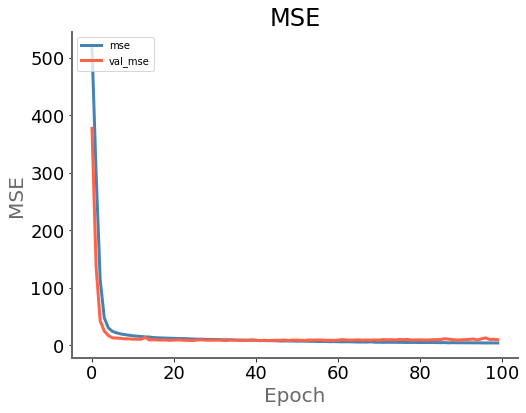

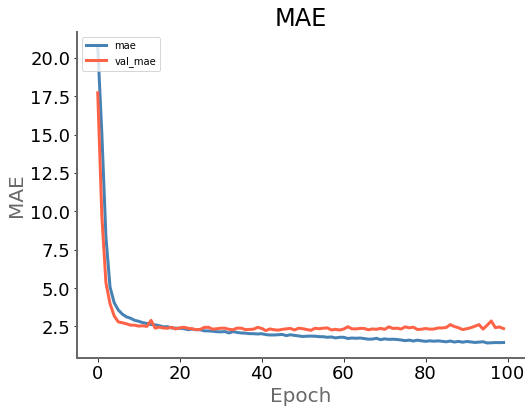

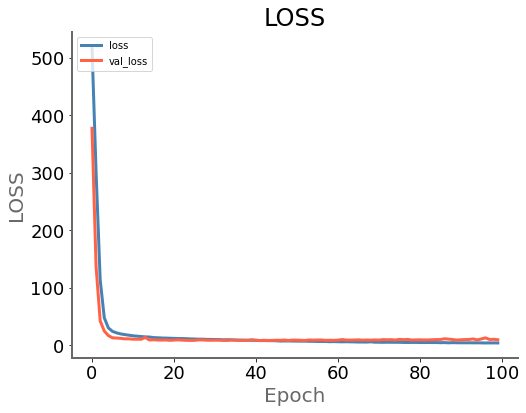

In [12]:
pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 8.3539
x_test / mae       : 2.2303
x_test / mse       : 8.3539


### 7.3 - Make a prediction

In [15]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [16]:
predictions = loaded_model.predict( my_data )
print("Prediction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], real_price))

Prediction : 9.02 K$   Reality : 10.40 K$


In [17]:
pwk.end()

End time is : Tuesday 09 February 2021, 18:32:42
Duration is : 00:00:20 794ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>